# The data is in the csv file rental_info.csv. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Length of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise.

# **Importing necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor



# **Loading the dataset and investigating the fields**

In [ ]:
df = pd.read_csv("/content/rental_info.csv")
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [ ]:
date_cols = ['rental_date', 'return_date']
for i in date_cols:
    df[i] = pd.to_datetime(df[i], errors = 'coerce')
df['rental_length_days'] = df['return_date'] - df['rental_date']
df['rental_length_days'] = df['rental_length_days'].dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   rental_date         15861 non-null  datetime64[ns, UTC]
 1   return_date         15861 non-null  datetime64[ns, UTC]
 2   amount              15861 non-null  float64            
 3   release_year        15861 non-null  float64            
 4   rental_rate         15861 non-null  float64            
 5   length              15861 non-null  float64            
 6   replacement_cost    15861 non-null  float64            
 7   special_features    15861 non-null  object             
 8   NC-17               15861 non-null  int64              
 9   PG                  15861 non-null  int64              
 10  PG-13               15861 non-null  int64              
 11  R                   15861 non-null  int64              
 12  amount_2            15861 non-nu

In [ ]:
df["deleted_scenes"] =  np.where(df["special_features"].str.contains("Deleted Scenes"), 1,0)
df['behind_the_scenes'] = np.where(df['special_features'].str.contains('Behind the Scenes'),1, 0)
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


# **EDA**

## Univariate Analysis

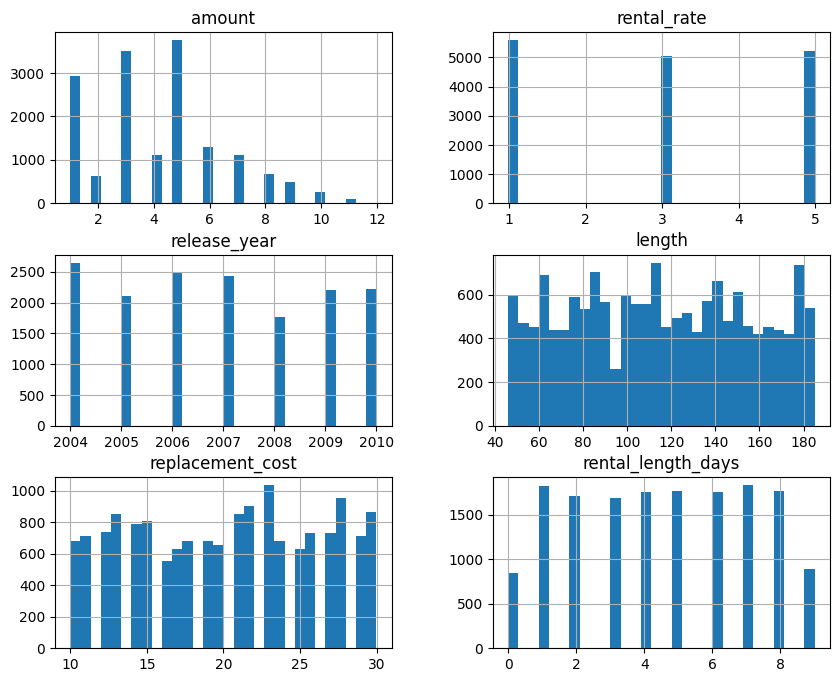

In [ ]:
numerical_cols = ['amount', 'rental_rate', 'release_year', 'length', 'replacement_cost', 'rental_length_days']
df[numerical_cols].hist(bins=30, figsize=(10, 8))
plt.show()

special_features
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Delete

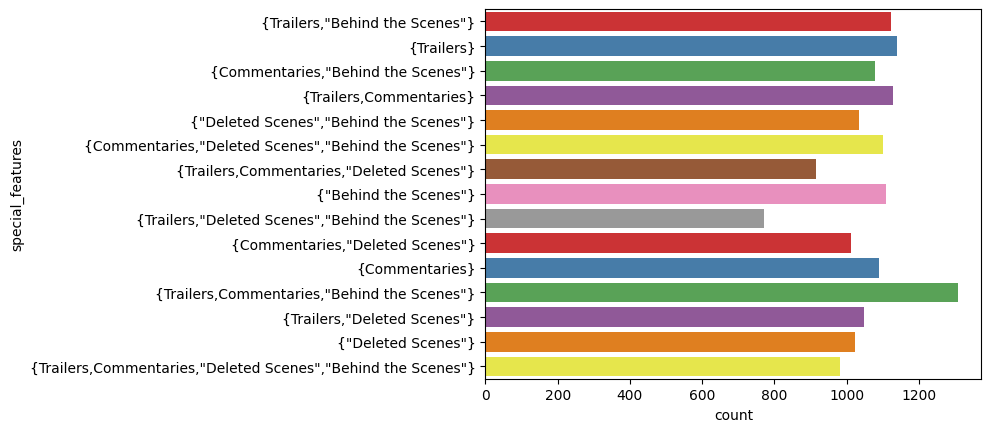

In [ ]:
print(df['special_features'].value_counts())
sns.countplot(y='special_features', data=df, palette='Set1')
plt.show()

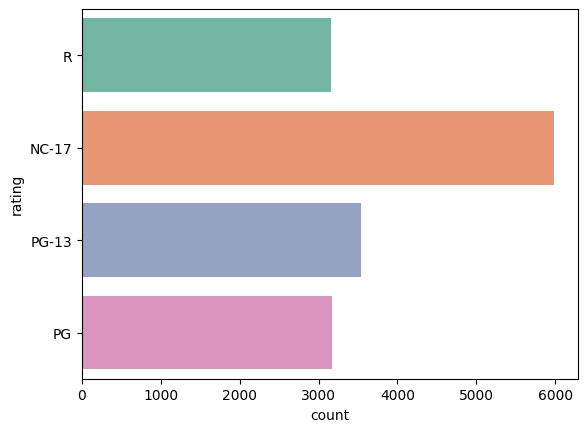

In [ ]:
df_2 = df.copy()
df_2['rating'] = df_2[['NC-17', 'PG', 'PG-13', 'R']].idxmax(axis=1)
sns.countplot(y='rating', data=df_2, palette='Set2')
plt.show()

## Bivariate Analysis and Multivariate Analysis

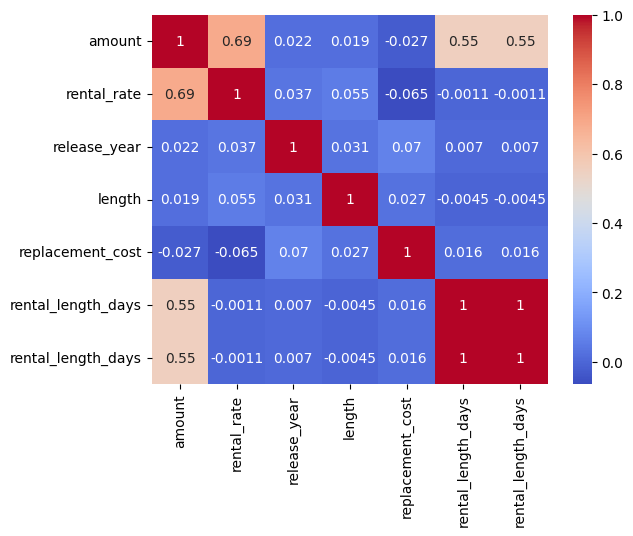

In [ ]:
corr = df[numerical_cols + ['rental_length_days']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

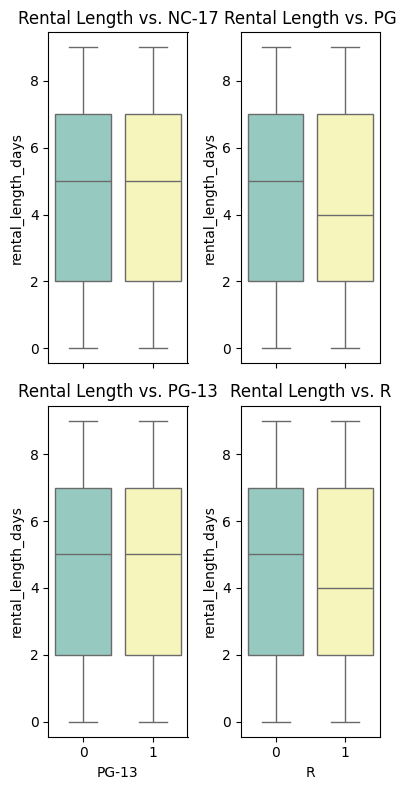

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 8), sharex=True)

ratings = ['NC-17', 'PG', 'PG-13', 'R']

axes = axes.flatten()

for i, rating in enumerate(ratings):
    sns.boxplot(x=rating, y='rental_length_days', data=df, palette='Set3', ax=axes[i])
    axes[i].set_title(f'Rental Length vs. {rating}')

plt.tight_layout()
plt.show()

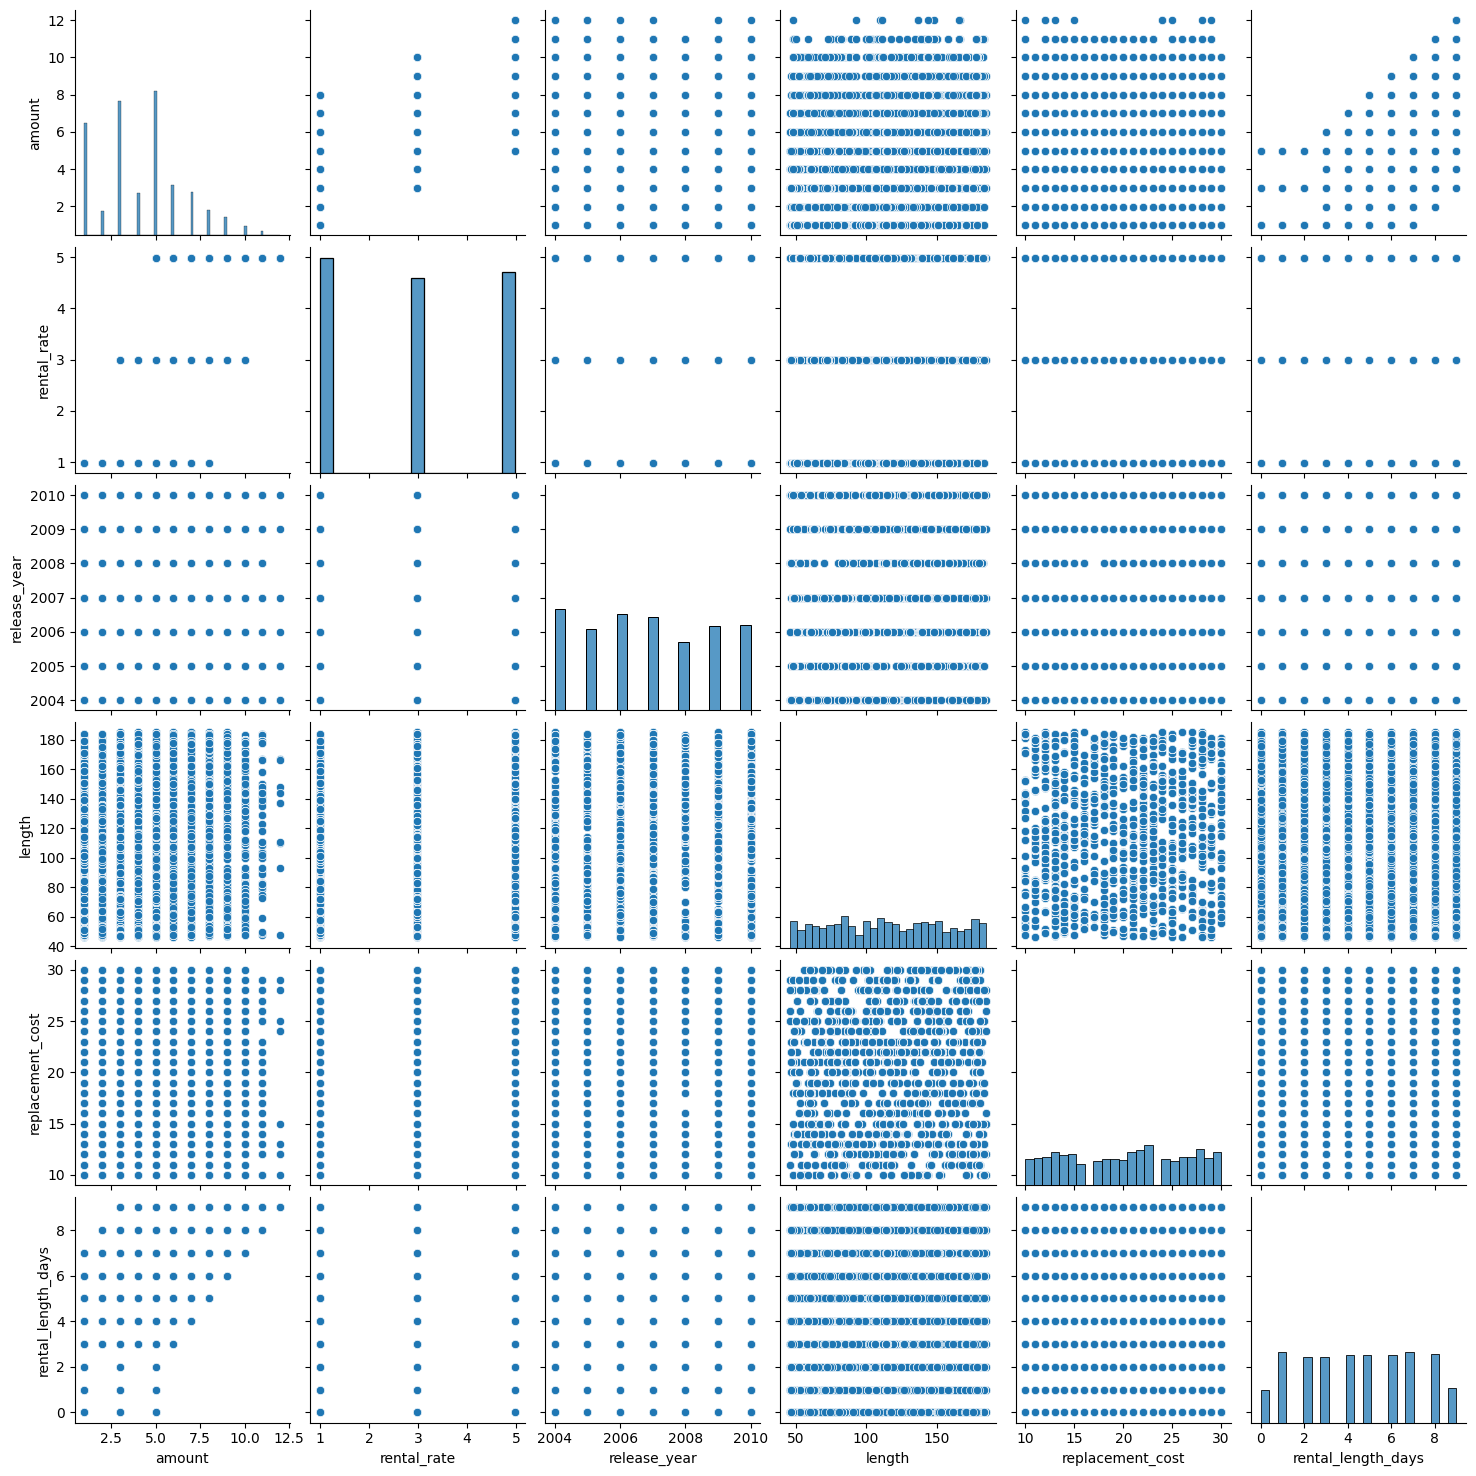

In [ ]:
sns.pairplot(df[numerical_cols])
plt.fig_size = (10,10)
plt.show()

### Numerical columns metrics

             amount   rental_rate  release_year        length  \
count  15861.000000  15861.000000  15861.000000  15861.000000   
mean       4.217161      2.944101   2006.885379    114.994578   
std        2.360383      1.649766      2.025027     40.114715   
min        0.990000      0.990000   2004.000000     46.000000   
25%        2.990000      0.990000   2005.000000     81.000000   
50%        3.990000      2.990000   2007.000000    114.000000   
75%        4.990000      4.990000   2009.000000    148.000000   
max       11.990000      4.990000   2010.000000    185.000000   

       replacement_cost  rental_length_days  
count      15861.000000        15861.000000  
mean          20.224727            4.525944  
std            6.083784            2.635108  
min            9.990000            0.000000  
25%           14.990000            2.000000  
50%           20.990000            5.000000  
75%           25.990000            7.000000  
max           29.990000            9.000000  


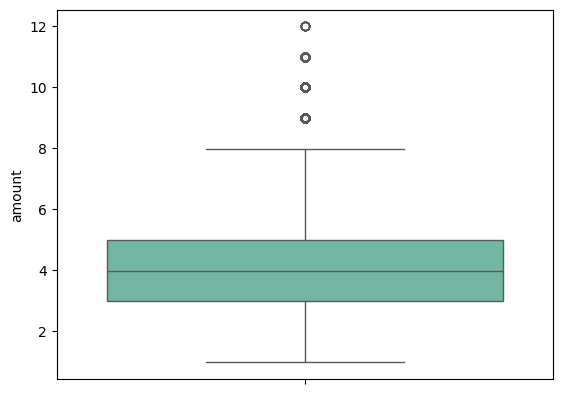

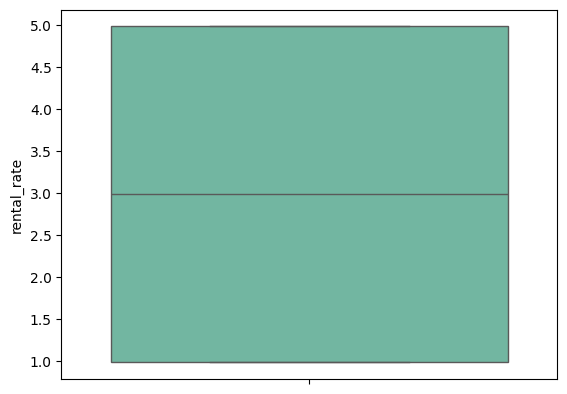

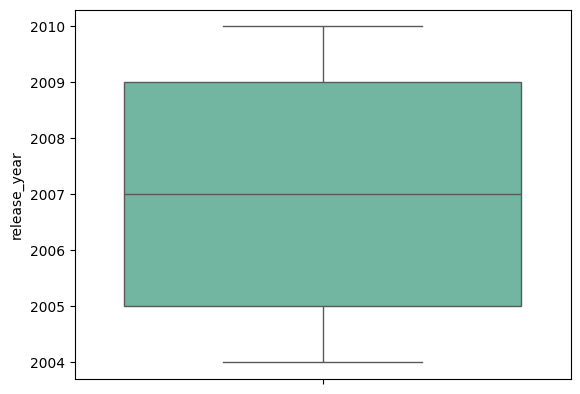

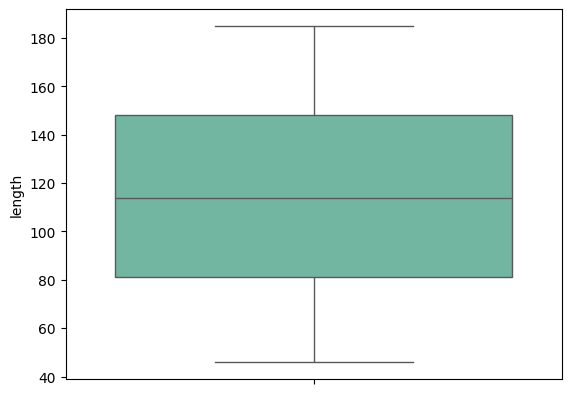

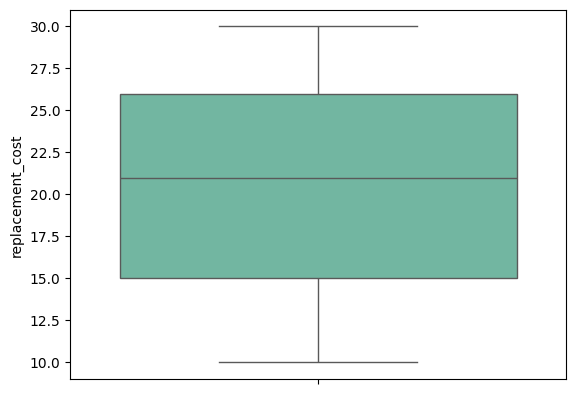

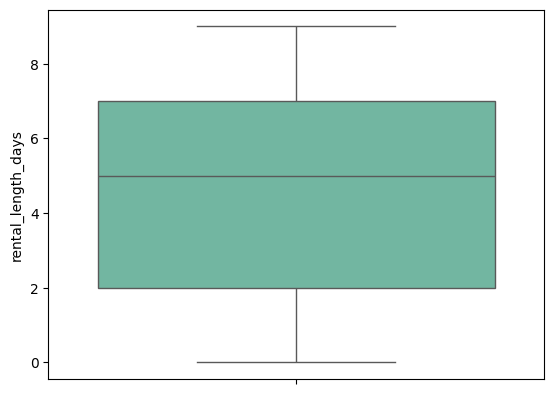

In [ ]:
print(df_2[numerical_cols].describe())

for column in numerical_cols:
  sns.boxplot(df[column], palette='Set2')
  plt.show()

The outliers seen in the amount columns may come from movies that are famous and expensive to buy.

# **Feature selection and pre-processing**

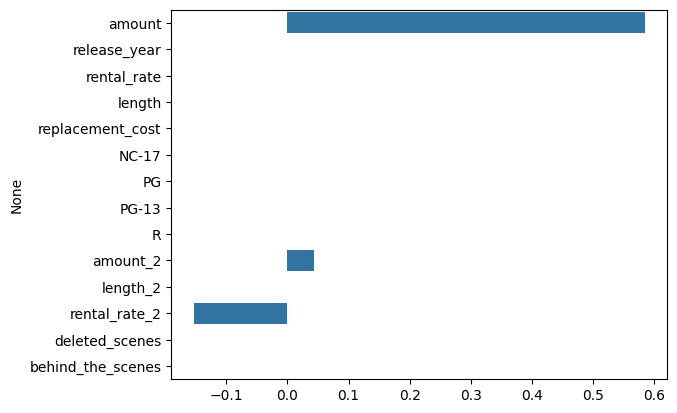

In [ ]:
#Selecting features to train the model upon
cols_to_drop = ['rental_length_days', 'rental_date', 'return_date', 'special_features']
X = df.drop(cols_to_drop, axis=1)
y = df['rental_length_days']
lasso = Lasso(alpha= 0.3, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
lasso.fit(X_train, y_train)
lasso_coefs = lasso.coef_
sns.barplot(x=lasso.coef_, y=X_train.columns)
plt.show()

In [ ]:
#splitting the dataset to have desired columns
X_train, X_test = X_train.iloc[:, lasso_coefs!=0], X_test.iloc[:, lasso_coefs!=0]

# **Model training without Hyper-parameter tuning and cross-validation**

In [ ]:
#without cross validation
models = { 'Ridge': Ridge(),
            'Lasso': Lasso(alpha=0.5),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=9),
            'Linear Regression': LinearRegression(),
            'KNN': KNeighborsRegressor(n_neighbors=5)
            }
results_noncv = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = MSE(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_noncv[name] = {
        'Test MSE': mse,
        'Test R2': r2
        }

for name, item in results_noncv.items():
  print(f"{name}:")
  print(f"  Test MSE: {item['Test MSE']:.4f}")
  print(f"  Test R2: {item['Test R2']:.4f}")

Ridge:
  Test MSE: 3.0924
  Test R2: 0.5644
Lasso:
  Test MSE: 3.7138
  Test R2: 0.4769
Random Forest:
  Test MSE: 2.3929
  Test R2: 0.6629
Linear Regression:
  Test MSE: 3.0924
  Test R2: 0.5644
KNN:
  Test MSE: 2.9209
  Test R2: 0.5886


# **Model training with hyper-parameter tuning and cross-validation**

In [ ]:
#with cross validation and hyper parameter tuning

results_cv = {}
models_cv = {
    'Ridge': {
        'model': Ridge(),
        'param_grid': {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0]}
    },
    'Lasso': {
        'model': Lasso(),
        'param_grid': {'alpha': [0.1, 0.5, 1.0]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=9),
        'param_grid': {
            'n_estimators': np.arange(1,101,1),
            'max_depth': np.arange(1,11,1),
            'min_samples_split': np.arange(5,12,1)
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': np.arange(3,9,1),
            'weights': ['uniform', 'distance']
        }
    }
}
for name, model in models_cv.items():
    rscv = RandomizedSearchCV(model['model'],
                                 param_distributions=model['param_grid'],
                                 cv=5,
                                 scoring='neg_mean_squared_error',
                                 n_jobs=-1,
                                 random_state=9)
    rscv.fit(X_train, y_train)
    best_params = rscv.best_params_
    model['model'].set_params(**best_params)
    model['model'].fit(X_train, y_train)
    y_pred = model['model'].predict(X_test)
    mse = MSE(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_mse = -rscv.best_score_
    results_cv[name] = {
        'Best Params': rscv.best_params_,
        'CV MSE': cv_mse,
        'Test MSE': mse,
        'Test R2': r2
        }


In [ ]:
for name, item in results_cv.items():
    print(f"{name}:")
    print(f"  Best Params: {item['Best Params']}")
    print(f"  CV MSE: {item['CV MSE']:.4f}")
    print(f"  Test MSE: {item['Test MSE']:.4f}")
    print(f"  Test R2: {item['Test R2']:.4f}")

Ridge:
  Best Params: {'alpha': 0.001}
  CV MSE: 2.9742
  Test MSE: 3.0924
  Test R2: 0.5644
Lasso:
  Best Params: {'alpha': 0.1}
  CV MSE: 2.9988
  Test MSE: 3.1178
  Test R2: 0.5608
Random Forest:
  Best Params: {'n_estimators': np.int64(83), 'min_samples_split': np.int64(9), 'max_depth': np.int64(10)}
  CV MSE: 2.3082
  Test MSE: 2.3911
  Test R2: 0.6632
KNN:
  Best Params: {'weights': 'distance', 'n_neighbors': np.int64(8)}
  CV MSE: 2.5775
  Test MSE: 2.6079
  Test R2: 0.6327
